In the previous training of Resnet 50, most of the errors were "neighbor errors" in which the predicted class was next to the true class. There were only 5 classes, which meant that each class included a broad range of focus levels. To attempt to improve on this, I re-wrote the image sorter to include 7 classes.

0) Very out negative 1) Medium out negative 2) Slightly out negative 3) Acceptable 4) Slightly out positive 5) Medium out positive 6) Very out positive

After training on a 7 class classifer, the model continued to struggle with telling one class from the other, while staying very accurate with telling whether the current image was above or below the best focal plane. I decided to try training on only 3 classes:

0) Out of focus negative (below)
1) Acceptable 
2) Out of focus positive (above)

This notebook documents training and evaluation with only 3 classes.

In [1]:
# Quick check to see how many images there are per class

def count_images(file_path):
    # Finds class folders, makes a list of classes, and counts how many images are in each class
    import os
    from pathlib import Path
    
    image_counter = []
    
    for class_name in os.listdir(file_path):
        # Exclude .DS_Store
        if class_name != '.DS_Store':

            # Make a Path to the class directory
            class_dir = Path(file_path) / class_name

            # Note that this is set to work with .png images and needs modification
            # to work with other types
            image_counter.append(len(os.listdir(class_dir)))
                          
    return image_counter

In [2]:
train_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
train_counts = count_images(train_path)
train_counts

[412, 38, 405]

In [3]:
test_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
test_counts = count_images(test_path)
test_counts

[412, 40, 448]

Unsurprisingly, the number of out of focus images is MUCH larger than in focus images. Annotating more stacks to get more training material is one path forward to improve performance here.

In [4]:
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# These last two are used to save info about how the training progressed
import pickle
import datetime

# Set the full path to the main image directory
train_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
test_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
num_train = 10
num_test = 10

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

traindata = wormDataset(train_dir, means, stds)
testdata = wormDataset(test_dir, means, stds)

# Load from the training and test sets
trainloader = torch.utils.data.DataLoader(traindata, batch_size=num_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_test, shuffle=True)

# Get the classes
class_names = traindata.classes
print('Detected ' + str(len(class_names)) + ' classes in training data')
print(class_names)

# Print out how many images are in the trainloader and testloader
print("Train batch size = " + str(num_train) + ', test batch size = ' + str(num_test))
print('Trainloder length = ' + str(len(trainloader)) + ', testloader length = ' + str(len(testloader)))

Detected 3 classes in training data
['0', '1', '2']
Train batch size = 10, test batch size = 10
Trainloder length = 86, testloader length = 90


In [5]:
%%capture 
# Prevent printing out the model architecture
# Check if cuda is available, and set pytorch to run on GPU or CPU as appropriate
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda available, running on GPU')
else:
    device = torch.device("cpu")
    print('Cuda is not available, running on CPU')
    # Give the user a message so they know what is going on

model = models.resnet50(pretrained=True)
#print(model) 
# Printing the model shows some of the internal layers, not expected to
# understand these but neat to see

# Freeze the pre-trained layers, no need to update featue detection
for param in model.parameters():
    param.requires_grad = False

# Get the number of features the model expects in the final fully connected layer, this is different
# in different models
num_ftrs = model.fc.in_features

# Re-define the final fully connected layer (model.fc, fc = fully connected)
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), # 2048 inputs to 512 outputs 
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 # The next line needs to be modified for the number of classes
                                 # in the data set. For the microscope images I currently have 
                                 # five classes, so there are 5 outputs
                                 nn.Linear(512, 3), # 512 inputs to 3 outputs
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [6]:
# Train the network
epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_tracker = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_tracker.append(accuracy/len(testloader))                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'resnet50_3cat.pth')

Epoch 1/2.. Train loss: 1.617.. Test loss: 0.370.. Test accuracy: 0.879
Epoch 1/2.. Train loss: 0.247.. Test loss: 1.199.. Test accuracy: 0.734
Epoch 1/2.. Train loss: 0.695.. Test loss: 0.780.. Test accuracy: 0.829
Epoch 1/2.. Train loss: 0.379.. Test loss: 0.389.. Test accuracy: 0.834
Epoch 1/2.. Train loss: 0.270.. Test loss: 0.306.. Test accuracy: 0.937
Epoch 1/2.. Train loss: 0.605.. Test loss: 0.222.. Test accuracy: 0.911
Epoch 1/2.. Train loss: 0.430.. Test loss: 0.188.. Test accuracy: 0.931
Epoch 1/2.. Train loss: 0.328.. Test loss: 0.193.. Test accuracy: 0.934
Epoch 2/2.. Train loss: 0.245.. Test loss: 0.166.. Test accuracy: 0.941
Epoch 2/2.. Train loss: 0.388.. Test loss: 0.194.. Test accuracy: 0.919
Epoch 2/2.. Train loss: 0.291.. Test loss: 0.245.. Test accuracy: 0.920
Epoch 2/2.. Train loss: 0.304.. Test loss: 0.280.. Test accuracy: 0.894
Epoch 2/2.. Train loss: 0.675.. Test loss: 0.140.. Test accuracy: 0.944
Epoch 2/2.. Train loss: 0.827.. Test loss: 0.165.. Test accuracy

In [7]:
# Save the information about how training went
# Get a unique date and time to id this training round
now = datetime.datetime.now()
time_string = ('-').join([str(now.hour), str(now.minute)]) 
date_string = ('-').join([str(now.month), str(now.day), str(now.year)])
file_name = ('_').join(['resnet50_3cat_training', date_string, time_string])

fileObject = open(file_name, 'wb')
training_data = [train_losses, test_losses, accuracy_tracker]
pickle.dump(training_data, fileObject)
fileObject.close
fileObject.close()

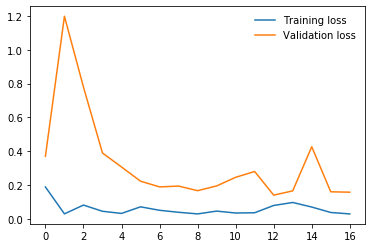

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

The model got to high accuracy and a low training loss very quickly, but has a tendency to do worse on some rounds. I wonder if this could have something to do with the relatively small number of acceptable focus samples and would get better with more samples.

In [9]:
# Evaluate on all images in the test loader
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on 900 test images: 91 %


In [10]:
# Make a confusion matrix to look at error types
confusion_matrix = np.zeros((3, 3))

with torch.no_grad():
    for data in testloader:
        # This is processing in batches, the number of things in images and labels is the
        # the same as the batch size
        images, labels = data
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        num_labels = labels.size(0)
        total += num_labels
        for i in range(num_labels): # Iterate through the labels in the batch
            
            # Increase the cell corresponding to the label / prediction pair by one
            confusion_matrix[labels[i], predicted.indices[i]] += 1
            
print(confusion_matrix)

[[386.   0.  26.]
 [ 11.   0.  29.]
 [ 10.   0. 438.]]


This is really interesting, because the number of out of focus images is so much higher than the acceptable images the model has trained itself to NEVER classify an image as acceptable. That's no good!

There are ways to correct for bias in the training data of this type. It's probably a good idea to start doing this for all numbers of categories since there are 40 focus planes and only 3 are considered acceptable.